In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil
from keras import layers
from keras import losses
from keras.regularizers import L2
from keras import metrics
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from keras import optimizers

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/PCOSGen-train")

In [ ]:
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/PCOSGen-train/class_label.xlsx"
df = pd.read_excel(dataset_path)
df.head()

,imagePath,Healthy
0,100image13.jpg,1
1,100image2.jpg,1
2,100image65.jpg,0
3,100image71.jpg,0
4,100image83.jpg,0


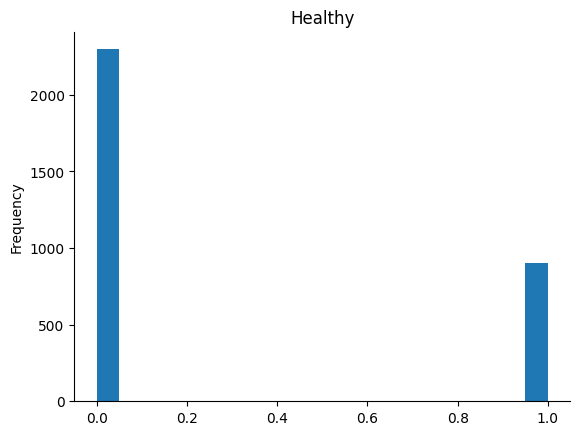

In [ ]:
df['Healthy'].plot(kind='hist', bins=20, title='Healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
directory_path = r"/content/drive/My Drive/Colab Notebooks/PCOSGen-train/Image Dataset"
CLASS_NAMES = ["Healthy", "Unhealthy"]
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    class_names = CLASS_NAMES,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'both'
)
# plt.figure(figsize=(10, 10))
# for images, labels in training_dataset.take(1):
#   for i in range(16):
#     ax = plt.subplot(4, 4, i+1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(CLASS_NAMES[labels[i].numpy().astype('uint8')[0]])
#     plt.axis("off")
# plt.show()
resize_rescale_layers = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])
augment_layers = tf.keras.Sequential([
    layers.RandomRotation(factor = (-0.025,0.025),),
    layers.RandomFlip(mode = 'horizontal',),
    layers.RandomContrast(factor = 0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label
training_dataset = (training_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_dataset.prefetch(tf.data.AUTOTUNE))
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 1024,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 2
}
lenet_model = tf.keras.Sequential([
    layers.InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),
    layers.Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS']*2 + 4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    layers.Flatten(),
    layers.Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    layers.Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),

    layers.Dense(1, activation = 'sigmoid')

])
lenet_model.summary()
lenet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_94 (Ba  (None, 254, 254, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                

In [ ]:
def prepareLabels(model, dataset):
  y_true = []
  y_pred = []

  for image,label in dataset:
    for i in range(32):
      y_true.append(label[i].numpy().astype('uint8')[0])

  for image, label in dataset:
    for i in range(32):
      value = model.predict(tf.expand_dims(image[i], axis = 0))[0][0]
      if (value>=0.5):
        y_pred.append(1)
      else:
        y_pred.append(0)
  return y_true, y_pred

In [ ]:
def box(lamda):
  r_x = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, 256)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, 256)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, 256)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, 256)

  r_w = x_b_r - r_x
  if (r_w==0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h==0):
    r_h = 1

  return r_y, r_x, r_h, r_w

def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, 256, 256)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, 256, 256)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w*r_h)/(256**2), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image,label

train_dataset_1 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

training_dataset_cutmix = (mixed_dataset.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

training_dataset_cutmix

valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate

def inceptionModule_1():
  conv_1x1 = Conv2D(6, kernel_size = (1, 1), stride = (1, 1), activation = 'relu')
  conv_2x2 = Conv2D(6, kernel_size = (3, 3), stride = (1, 1), activation = 'relu')
  conv_5x5 = Conv2D(6, kernel_size = (5, 5), stride = (1, 1), activation = 'relu')

  inceptionModule_1 = concatenate([conv_1x1, conv_2x2, conv_5x5])

  return inceptionModule_1

def inceptionModule_2():
  conv_1x1  = Conv2D(6, kernel_size = (1, 1), stride = (1, 1), activation = 'relu')

  conv_1x1_2 = Conv2D(6, kernel_size = (1, 1), stride = (1, 1), activation = 'relu')
  conv_1x1_2 = Conv2D(6, kernel_size = (1, 1), stride = (1, 1), activation = 'relu')(conv_1x1_2)

  conv_3x3 = Conv2D(6, kernel_size = (3, 3), stride = (1, 1), activation = 'relu')
  conv_3x3 = Conv2D(6, kernel_size = (1, 1), stride = (1, 1), activation = 'relu')(conv_3x3)

  conv_5x5 = Conv2D(6, kernel_size = (5, 5), stride = (1, 1), activation = 'relu')
  conv_5x5 = Conv2D(6, kernel_size = (1, 1), stride = (1, 1), activation = 'relu')(conv_5x5)

  inceptionModule_2 = concatenate([conv_1x1, conv_1x1_2, conv_3x3, conv_5x5])

  return inceptionModule_2

def build_model():
  myModel = models.Sequential()

  myModel.add(layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu'))
  myModel.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

  #INCEPTION MODULE-1
  myModel.add(inceptionModule_1())

  #INCEPTION MODULE-2
  myModel.add(inceptionModule_2())

  myModel.add(layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu'))
  myModel.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

  #Flattening
  myModel.add(layers.Flatten())
  myModel.add(layers.Dense(1000, activation = 'relu'))
  myModel.add(layers.Dense(1000, activation = 'relu'))
  myModel.add(layers.Dense(6, activation = 'softmax'))

  return myModel

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)
backbone.trainable = False
CONFIGURATION["N_DENSE_1"]
model = tf.keras.Sequential([
    layers.Input(shape = (256, 256, 3)),
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])
model.summary()
model.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])

71686520/71686520 [==============================] - 4s 0us/step


In [ ]:
history = model.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def inceptionModule_1():
    conv_1x1 = Conv2D(6, kernel_size=(1, 1), strides=(1, 1), activation='relu')
    conv_2x2 = Conv2D(6, kernel_size=(3, 3), strides=(1, 1), activation='relu')
    conv_5x5 = Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu')

    inceptionModule_1 = concatenate([conv_1x1, conv_2x2, conv_5x5])

    return inceptionModule_1

def inceptionModule_2():
    conv_1x1 = Conv2D(6, kernel_size=(1, 1), strides=(1, 1), activation='relu')

    conv_1x1_2 = Conv2D(6, kernel_size=(1, 1), strides=(1, 1), activation='relu')
    conv_1x1_2 = Conv2D(6, kernel_size=(1, 1), strides=(1, 1), activation='relu')(conv_1x1_2)

    conv_3x3 = Conv2D(6, kernel_size=(3, 3), strides=(1, 1), activation='relu')
    conv_3x3 = Conv2D(6, kernel_size=(1, 1), strides=(1, 1), activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu')
    conv_5x5 = Conv2D(6, kernel_size=(1, 1), strides=(1, 1), activation='relu')(conv_5x5)

    inceptionModule_2 = concatenate([conv_1x1, conv_1x1_2, conv_3x3, conv_5x5])

    return inceptionModule_2


In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)
backbone.trainable = False
CONFIGURATION["N_DENSE_1"]
model = tf.keras.Sequential([
    layers.Input(shape = (256, 256, 3)),
    backbone,
    inceptionModule_1(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    layers.BatchNormalization(),
    inceptionModule_2(),
    layers.Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])
model.summary()
model.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])

TypeError: object of type 'NoneType' has no len()

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)

inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)

backbone.trainable = False

inception.trainable = False

def inceptionModule_1(x):
  conv_1x1 = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(x)
  conv_2x2 = layers.Conv2D(6, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)
  conv_5x5 = layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu')(x)

  conv_1x1 = layers.Resizing(256,256)(conv_1x1)
  conv_2x2 = layers.Resizing(256,256)(conv_2x2)
  conv_5x5 = layers.Resizing(256,256)(conv_5x5)

  inceptionModule_1 = layers.concatenate([conv_1x1, conv_2x2, conv_5x5])

  return inceptionModule_1

def inceptionModule_2(x):
  conv_1x1  = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(x)

  conv_1x1_2 = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(x)
  conv_1x1_2 = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(conv_1x1_2)

  conv_3x3 = layers.Conv2D(6, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)
  conv_3x3 = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(conv_3x3)

  conv_5x5 = layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu')(x)
  conv_5x5 = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(conv_5x5)

  conv_1x1 = layers.Resizing(256,256)(conv_1x1)
  conv_1x1_2 = layers.Resizing(256,256)(conv_1x1_2)
  conv_3x3 = layers.Resizing(256,256)(conv_3x3)
  conv_5x5 = layers.Resizing(256,256)(conv_5x5)


  inceptionModule_2 = layers.concatenate([conv_1x1, conv_1x1_2, conv_3x3, conv_5x5])

  return inceptionModule_2

inputs = layers.Input(shape = (256,256,3)),
x = backbone(inputs)

x = inceptionModule_1(x)
x = inceptionModule_2(x)

x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1, activation = 'sigmoid')(x)

model_2 = tf.keras.Model(inputs = inputs, outputs = output, name = 'test')

model_2.summary()

Model: "test"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnetb4 (Functional  (None, 8, 8, 1792)           1767382   ['input_7[0][0]']             
 )                                                        3                                       
                                                                                                  
 conv2d_200 (Conv2D)         (None, 8, 8, 6)              10758     ['efficientnetb4[0][0]']      
                                                                                                  
 conv2d_201 (Conv2D)         (None, 6, 6, 6)              96774     ['efficientnetb4[0][0]']   

In [ ]:
model_2.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model_2.fit(training_dataset, validation_data=valid_dataset, epochs=50, verbose=1)

Epoch 1/50
80/80 [==============================] - 291s 3s/step - loss: 0.5170 - accuracy: 0.7285 - val_loss: 0.4703 - val_accuracy: 0.7547
Epoch 2/50
80/80 [==============================] - 39s 472ms/step - loss: 0.4535 - accuracy: 0.7691 - val_loss: 0.4444 - val_accuracy: 0.7688
Epoch 3/50
80/80 [==============================] - 33s 405ms/step - loss: 0.4321 - accuracy: 0.7801 - val_loss: 0.4395 - val_accuracy: 0.7688
Epoch 4/50
80/80 [==============================] - 35s 410ms/step - loss: 0.4285 - accuracy: 0.7844 - val_loss: 0.4557 - val_accuracy: 0.7625
Epoch 5/50
80/80 [==============================] - 34s 407ms/step - loss: 0.4172 - accuracy: 0.7867 - val_loss: 0.4706 - val_accuracy: 0.7641
Epoch 6/50
80/80 [==============================] - 34s 411ms/step - loss: 0.4113 - accuracy: 0.7875 - val_loss: 0.4428 - val_accuracy: 0.7672
Epoch 7/50
80/80 [==============================] - 34s 413ms/step - loss: 0.4195 - accuracy: 0.7848 - val_loss: 0.4728 - val_accuracy: 0.7531
E

In [ ]:
drive_location = r"/content/drive/MyDrive/Colab Notebooks/"
model_filename = "efficientnet_b4_model_04_02_24_1.keras"
model_2.save(drive_location + model_filename)

In [ ]:
model.evaluate(valid_dataset)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()